In [38]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def RF_complete(data_t: "df", data_s_list: "list(df)", feature_t, n_tree=50, n_feature=5, f_sample=0.3, n_best_tree=5):
    '''
    TODO:
    - data_s_list might be a list of dataframes... Not just a list corresponding to one thing
    '''
    K = len(data_s_list) # Number of datasets given for training
    print(f"{K} additional datasets used for prediction.")

    if feature_t not in data_t.columns:
        print("Feature-of-interest not found in data_t! Please check column names of input data.")
        return None
    else:
        print("Feature-of-interest located!")

    mu = []
    sigma = []

    for k in range(0, K): # Iteratingg over data_s_list
        data_assist = data_s_list[k] #.iloc[k-1] # Indexing is in terms of rows
        # Locate feature of interest in training dataset k of K
        if feature_t in data_assist.columns:
            f_t_ind = list(data_assist.columns).index(feature_t) # Finds col/index of current sera that matches virus of interest
        else:
            print(f"feature_t not found in assisting data {k}!")
            continue
        # Check for feature match
#         if not data_t.columns.equals(data_assist.columns): # MISTAKE!!! -> Solved?
        if sum(data_t.columns != data_assist.columns) > 0: # Check for any non overlapping viruses between training dataset and prediction data
            print(f"Features not matched for assisting data {k}! Skipped to next data.")
            continue
        # Transferability function
        trans_true_err = []
        trans_pred_err = []
        print(f"data_assist shape: {data_assist.shape}")
        print(f"Iterating over {data_assist.shape[1]}")
        # Iterate over dataset columns
        for j in range(0, data_assist.shape[1]): # Iterate over rows of training data
            feature_trans = data_assist.columns[j]
#             if not data_t.iloc[:, j].isna().sum() > 0: # Check this for mistake
            if data_t.iloc[:, j].notna().sum() > 0:
                rf_1t1 = RF_complete_1t1(data_assist, data_t, feature_t=feature_trans, n_tree=n_tree,
                                         n_feature=n_feature, f_sample=f_sample, k=k)

                if rf_1t1 is not None: # Check to see that rf_1t1 is a val and not None or a bool
                    trans_true_err.extend(rf_1t1["true_err"])
                    trans_pred_err.extend(rf_1t1["pred_err"])

        if len(trans_true_err) == 0:
            continue
        else: # ooh tough cookie
            print("Doing lm stuff")
            lm_coeff = np.polyfit(trans_pred_err, trans_true_err, 1)
            a = lm_coeff[0]
            b = lm_coeff[1]
            c = np.sqrt(np.mean((a * np.array(trans_pred_err) + b - np.array(trans_true_err)) ** 2))

            def f_transfer(x, a, b, c):
                return max(x, a * x + b + c)

            print([f"a={round(a, 3)}", f"b={round(b, 3)}", f"c={round(c, 3)}"])

            rf_1t1 = RF_complete_1t1(data_assist, data_t, feature_t=feature_t, n_best_tree=n_best_tree, n_tree=n_tree,
                                     n_feature=n_feature, f_sample=f_sample, k=k)
            print(f"rf_1t1: {rf_1t1}")
            mu.append(rf_1t1["mu"])
            sigma.append(f_transfer(np.mean(rf_1t1["pred_err"]), a, b, c))

    A = 0
    B = 0
    tt = 0
    print(f"len sigma: {len(sigma)}")
    print(sigma)
    print(f"K: {K}")
    for k in range(K):
        print(f"k: {k}")
        if sigma[k] is not None:
            tt += 1
            A += mu[k] / sigma[k] ** 2
            B += 1 / sigma[k] ** 2

    print(f"{tt} assisting data used for prediction.")
    return {"predictions": A / B, "errors": 1 / np.sqrt(B)}

def RF_complete_1t1(data_assist, data_t, feature_t, n_tree=50, n_feature=5, f_sample=0.3, n_best_tree=5, k=1):
    if feature_t in data_assist.columns:
#         f_t_ind = data_assist.index.get_loc(feature_t)
        f_t_ind = list(data_assist.columns).index(feature_t)
    else:
        print(f"feature_t not found in assisting data {k}!")
        return None
    # IM WORKING ON THIS ... REFERS TO VIRUSES I THINK, NOT SERA. Yeah R code mentions finding feasible features
#     if (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).sum() > n_feature:
#         f_ind = data_assist.index[
#             (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8)].tolist()
    if (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).sum() > n_feature:
        # f_ind should be a list of columns/viruses
        f_ind = list(data_assist.columns[(data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).tolist()])
        if feature_t in f_ind:
            f_ind.remove(feature_t)
    else:
        print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        return None
    # Left off here
    f_tmp_ind = [data_t.columns.get_loc(f) for f in f_ind if f in data_t.columns]
    f_feasible = [f for f in data_t.columns[f_tmp_ind] if data_t[f].count() > 2]
    f_ind = [i for i in f_ind if i in f_feasible]
    f_ind = [f_ind[idx] for idx in range(len(f_ind)) if f_ind[idx] == f_feasible[idx]] # Added cuz the r code has this after f.feasible asgn
    if len(f_feasible) < 2:
        print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        return None

    data_assist = data_assist.dropna(subset=[feature_t])

    RMSE = []
    f_sel_ind = []
    tree = []

    for i in range(n_tree):
        f_sel_ind.append(np.random.choice(f_ind, n_feature, replace=True))
        sample_sel = np.random.choice(data_assist.shape[0], int(data_assist.shape[0] * f_sample), replace=True)
        # LAST ERROR: Indexing like this might be better:
        # data_assist.iloc[sample_sel][np.append(f_sel_ind[i],feature_t)]
        # We want to include the column of f_t_ind into our data_train
#         data_train = data_assist.iloc[sample_sel, f_sel_ind[i] + [f_t_ind]]
        data_train = data_assist.iloc[sample_sel][np.append(f_sel_ind[i],feature_t)]
        colm_t = data_train.apply(lambda x: x.mean(), axis=1)
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), colm_t).T
        data_train.columns = np.append(f_sel_ind[i], "target")
        ###get decision tree and RMSE
        # import xgboost as xgb
        # Fit the model to the data (handles missing values)
        # tree.append(xgb.XGBRegressor(max_depth=5, min_child_weight=5))
        # tree[i].fit(data_train.iloc[:, :-1], data_train["target"]) # Sometimes runs into nan somehow... ACTUALLY just for the outdated version of sklearn, new is fine
        tree.append(DecisionTreeRegressor(min_samples_split=5))
        tree[i].fit(data_train.iloc[:, :-1], data_train["target"])
        # Compile testing dataset
        data_test = data_assist.drop([data_assist.index[idx] for idx in sample_sel], axis=0)[np.append(f_sel_ind[i], feature_t)]
        colm_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), colm_t).T

        pred_t = tree[i].predict(data_test.iloc[:, :-1])
        RMSE.append(np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2)))
        
    ###predict in the target dataset
    pred_list = np.zeros((data_t.shape[0], n_best_tree))
    for i in range(n_best_tree):
        j = np.argsort(RMSE)
        f_t_ind = data_t.columns.get_loc(feature_t)
        f_t_sel_ind = [data_t.columns.get_loc(f) for f in f_sel_ind[j[i]]]
        data_test = data_t.iloc[:, np.append(f_t_sel_ind, f_t_ind)]
#         data_test = data_t.iloc[:, f_t_sel_ind + [f_t_ind]]
        colm_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), colm_t).T
        data_test.columns = np.append(f_sel_ind[j[i]], "target")
#         data_test.columns = f_sel_ind[j[i]] + ["target"] # hmmm...

        pred_t = tree[j[i]].predict(data_test.iloc[:, :-1])
        pred_t[np.where(data_test.iloc[:, :-1].isna().sum(axis=1) > 0)] = np.nan
        pred_list[:,i]=pred_t

    # Obtain predictions and errors
    true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
    argSortedRMSE = [RMSE[idx] for idx in np.argsort(RMSE)]
    pred_err = argSortedRMSE[:n_best_tree]
    mu = np.nanmean(pred_list, axis=1)
    return {'mu': mu, 'true_err': true_err, 'pred_err': pred_err}


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

In [40]:
def non_trivialize_df(df):
    # Search columns for trivial feature (virus)
    dropped = 0
    for idx, col in enumerate(df.columns):
        uniques = df[col].unique()
        num_unique = len(uniques)
        if num_unique == 1 and 'sera_table' not in col and "*" in uniques: # Critereon for a missing virus
#             print(idx, col, num_unique, uniques)
            df = df.drop(columns=col)
            dropped += 1 # Count dropped virus
    # Search rows for trivial entry (serum)
    for idx in list(df.index):
        num_unique = len(df.loc[idx].unique())
        if num_unique == 3: # Serum name and table name are 2 constant features.
#             print(idx, num_unique)
            df = df.drop(index=idx)
    df = df.replace("*", np.nan)
    df = df.set_index('Measurements (Sera in Rows/Viruses in Columns)')
    df = df.drop(['sera_table'], axis=1)
    df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
    # Return data and number of dropped viruses
    return df, dropped


def plot_heatmap(df):
    mask = df.isnull()
    g = sns.heatmap(df, cmap='gray',mask=mask)
    g.set_facecolor('xkcd:salmon')
    return g


def plot_heatmap_subplot(table_dict):
#     keys = sorted(list(table_dict.keys()))
    keys = ["TableS1", "TableS3", "TableS5", "TableS6", "TableS13", "TableS14"]
    N = len(keys)
    fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(30, 5))
    for idx, key in enumerate(keys):
        df, dropped_viruses = table_dict[key]
        percent_missing = sum(list(df.isna().sum())) / (df.shape[0] * df.shape[1]) # Proportion of missing vals in table
        df = np.log(df)
        sera_num = df.shape[0]
        virus_num = df.shape[1]
        mask = df.isnull()
        g = sns.heatmap(df,
                        xticklabels=False,
                        yticklabels=False,
                        cmap='gray',
                        mask=mask,
                        ax=axs[idx])
        g.set_facecolor('xkcd:salmon')
        axs[idx].set_xlabel(f'{sera_num} Sera x {virus_num} Viruses\n{percent_missing * 100:.2f}% Missing')
        axs[idx].set_title(key)
    return fig, axs

In [41]:
'''
data_t: DF of sera (table specific) X Viruses (No viruses dropped yet) to make prediction on
data_s_list: list of columns of data table for virus to train on ... Its the whole df I think
feature_t: A particular virus to predict (And I assume we omit this from training)
n_tree=50
n_feature=5
f_sample=0.3
n_best_tree=5
'''

flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables

flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}

predict_table = 'TableS14'
train_table = 'TableS13'
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables

data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
data_s_list = [data_s] # [[col] for col in list(data_s.columns)]
feature_t = "A/PANAMA/2007/99"

# K = len(data_s) # 160
# data_assist = data_s
# f_t_ind = list(data_assist.columns).index(feature_t)
# data_t.columns.equals(data_t.columns)
# f_t_ind = data_assist.columns.get_loc(feature_t)
# n_tree=50
# n_feature=5
# f_sample=0.3
# n_best_tree=5
# k=1

/tmp/ipykernel_326/759662303.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_326/759662303.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_326/759662303.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_326/759662303.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_326/759662303.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to

In [ ]:
results = RF_complete(data_t = data_t,
                      data_s_list=[data_s],
                      feature_t=feature_t)

In [ ]:
results

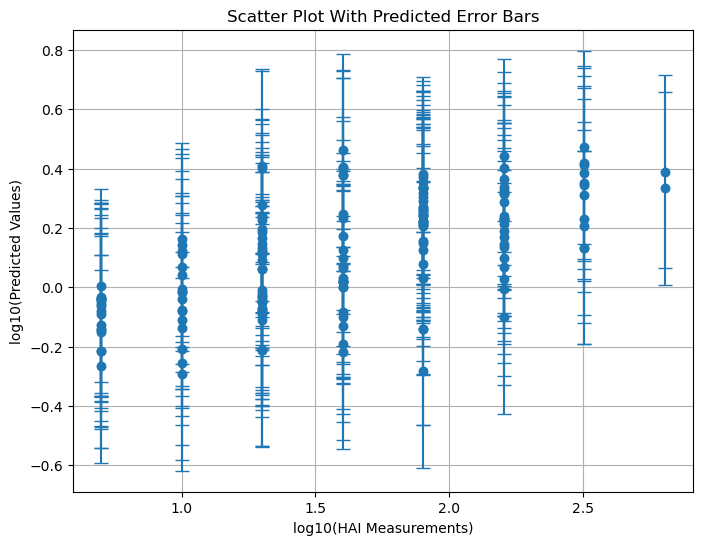

In [42]:
import matplotlib.pyplot as plt

# Assuming 'feature.t' is the feature you want to use as the x-axis
x_data = data_t[feature_t]

# 'out' contains the predictions
y_data = results['predictions']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(Predicted Values)")
plt.title("Scatter Plot With Predicted Error Bars")
plt.grid(True)


plt.errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")

# Actual prediction error (as n-folds)
# actual_error = 10 ** np.sqrt(np.mean((np.log10(y_train) - np.log10(y_pred)) ** 2))
# print("Actual Prediction Error (as n-folds):", actual_error)


plt.show()

In [43]:
data_t
predict_table

'TableS14'

In [44]:
data_df['sera_table'].unique()

array(['TableS1', 'TableS3', 'TableS5', 'TableS6', 'TableS13', 'TableS14'],
      dtype=object)

In [45]:
data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s_list = [
          data_df.loc[data_df['sera_table']=='TableS13'].drop(['sera_table'], axis=1),
          data_df.loc[data_df['sera_table']=='TableS6'].drop(['sera_table'], axis=1),
          data_df.loc[data_df['sera_table']=='TableS5'].drop(['sera_table'], axis=1),
         ]
feature_t = "A/PANAMA/2007/99"

In [46]:
out = RF_complete(data_t, data_s_list, feature_t)

3 additional datasets used for prediction.
Feature-of-interest located!
data_assist shape: (160, 81)
Iterating over 81
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)


/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (47, 5)
shape? (47

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)


/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
shape? (47, 5)
Doing lm stuff
['a=0.846', 'b=0.113', 'c=0.057']
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape? (48, 5)
shape?

/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76

/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (74, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)
shape? (75, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (76, 5)
shape? (0, 5)


/tmp/ipykernel_326/8796110.py:168: RuntimeWarning: Mean of empty slice
  true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
/tmp/ipykernel_326/8796110.py:171: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by DecisionTreeRegressor.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming 'data.t' is your training data, 'data.s.list' is your list of features, and 'feature.t' is your target feature.

# Define your features and target
X_train = data_t
y_train = data_s_list[0][feature_t]

# Initialize and fit the Random Forest model
# rf = RandomForestRegressor()
# rf.fit(X_train, y_train)

# Predict on the training data
y_pred = results['predictions']

# Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_train, y_pred))

# Plot the predicted values against the true values
plt.scatter(X_train[:, np.where(np.array(data_t[feature_t])[0][0]], np.log10(y_pred), label="Predicted Values")
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(Predicted Values)")

# Add error bars from predicted RMSE (in log10 scale)
plt.errorbar(X_train[:, np.where(np.array(colnames(data_t)) == feature_t)[0][0]], np.log10(y_pred),
             yerr=np.log10(rmse), fmt='o', capsize=5, label="Error Bars")

# Actual prediction error (as n-folds)
# actual_error = 10 ** np.sqrt(np.mean((np.log10(y_train) - np.log10(y_pred)) ** 2))
print("Actual Prediction Error (as n-folds):", actual_error)

# Predicted error (as n-folds)
predicted_error = 10 ** (np.std(np.log10(y_train) - np.log10(y_pred)))
print("Predicted Error (as n-folds):", predicted_error)

# Show the plot
plt.legend()
plt.show()


NameError: name 'colnames' is not defined